In [3]:
from pennylane import numpy as np
import torch
from torch import nn
import pennylane as qml
import matplotlib.pyplot as plt

import functools

# reproducibility
torch.manual_seed(0)
np.random.seed(0)

In [15]:
from torch.utils.data import TensorDataset, Dataset

In [16]:
d = TensorDataset(torch.rand(100, 10))

In [20]:
isinstance(d, TensorDataset)

True

In [2]:
def deterministic(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        torch.manual_seed(0)
        np.random.seed(0)
        value = func(*args, **kwargs)
        return value
    return wrapper

(<Figure size 1400x500 with 1 Axes>, <Axes: >)

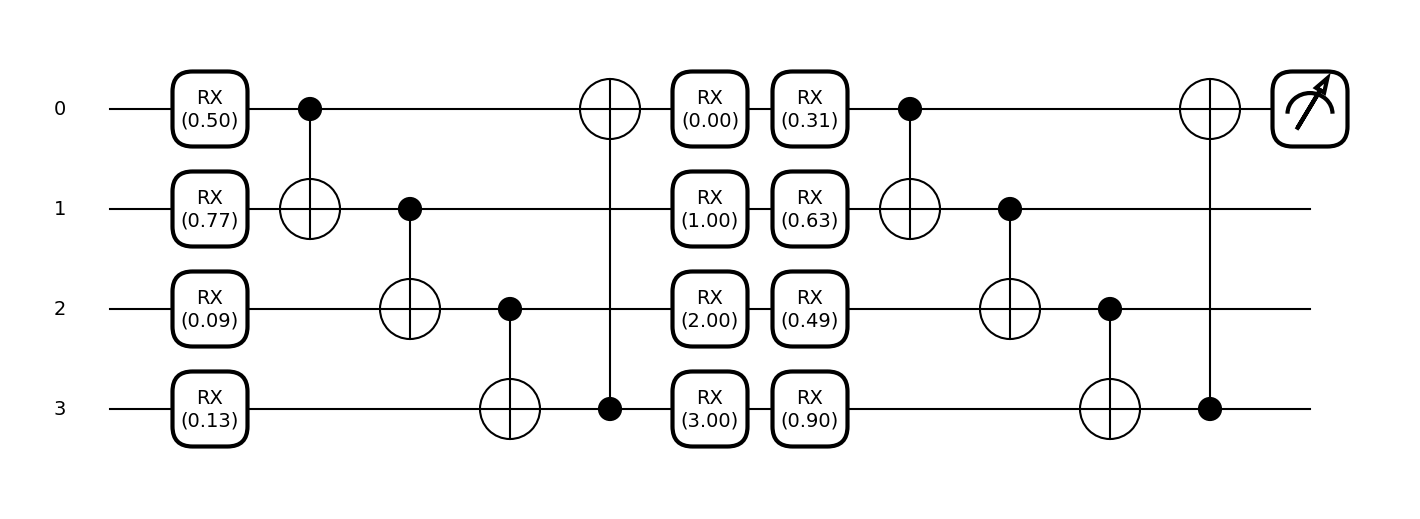

In [19]:
n_qubits = 4
n_depth = 1
n_layers = 1
in_dim = n_qubits * n_depth
dev = qml.device("lightning.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
@deterministic
def circuit(inputs, w):
    qml.BasicEntanglerLayers(w[0], wires=range(n_qubits), rotation=qml.RX)
    
    for i in range(n_depth):
        qml.AngleEmbedding(features=inputs[i*n_qubits : (i+1)*n_qubits],
                           wires=range(n_qubits),
                           rotation="X")
        qml.BasicEntanglerLayers(w[i+1],
                                 wires=range(n_qubits),
                                 rotation=qml.RX)
        
    return [qml.expval(qml.PauliZ(k)) for k in range(1)]

weight_shapes = {"w": (n_depth+1, n_layers, n_qubits)}

qml.draw_mpl(circuit, decimals=2, expansion_strategy='device')(inputs=torch.arange(n_qubits*n_depth, dtype=float),
                                                               w=torch.rand(weight_shapes["w"]))

In [20]:
class FreqNet(nn.Module):
    @deterministic
    def __init__(self, circuit, weight_shapes):
        super().__init__()
        self.qlayer = qml.qnn.TorchLayer(circuit, weight_shapes)
    def forward(self, X):
        X = X.view(-1, 1)
        X = X.expand(-1, in_dim)
        X = self.qlayer(X).view(-1, 1)
        return X

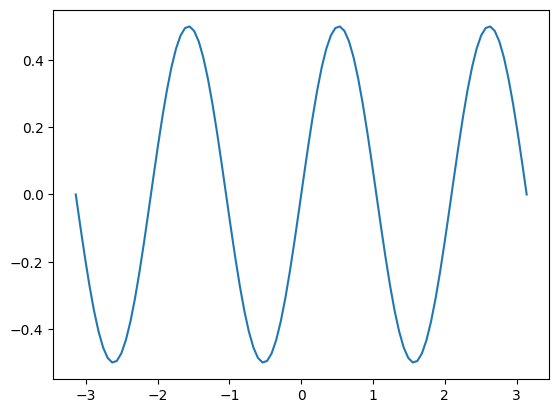

In [32]:
f = lambda x: 0.5 * np.sin(3*x)
x = np.linspace(-np.pi, np.pi, 100)
plt.plot(x, f(x))

In [33]:
def draw(net):
    y_exact = f(x)
    with torch.no_grad():
        X = torch.tensor(x, dtype=torch.float32)
        y_pred = net(X).numpy()
    
    plt.figure()
    plt.plot(x, y_exact, label="true")
    plt.plot(x, y_pred, label="pred")
    plt.legend()
    plt.show()

def train_adam(net, epochs=100):
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
    criterion = nn.MSELoss()
    y_exact = torch.tensor(f(x), dtype=torch.float32)
    
    print("Started Adam training...")
    for e in range(epochs):
        optimizer.zero_grad()
        X = torch.tensor(x, dtype=torch.float32)
        y_pred = net(X).flatten()
        loss = criterion(y_exact, y_pred)
        loss.backward()
        optimizer.step()
    
        print(f"Epoch: {e}\t Loss: {loss.item()}")

def train_lbfgs(net, epochs=10):
    
    def closure():
        optimizer.zero_grad()
        y_pred = net(X)
        loss = criterion(y_exact, y_pred)
        loss.backward()
        return loss
        
    
    optimizer = torch.optim.LBFGS(net.parameters(), lr=0.1)
    criterion = nn.MSELoss()
    
    print("Started L-BFGS training...")
    for e in range(epochs):
        y_exact = torch.tensor(f(x), dtype=torch.float32)
        X = torch.tensor(x, dtype=torch.float32)
        l = optimizer.step(closure)
        
        print(f"Epoch: {e}\t Loss: {l.item()}")

In [34]:
net = FreqNet(circuit, weight_shapes)

In [37]:
train_adam(net, epochs=100)

Started Adam training...
Epoch: 0	 Loss: 0.03248976171016693
Epoch: 1	 Loss: 0.03202752023935318
Epoch: 2	 Loss: 0.0316368006169796
Epoch: 3	 Loss: 0.03134201467037201
Epoch: 4	 Loss: 0.031138233840465546
Epoch: 5	 Loss: 0.031013159081339836
Epoch: 6	 Loss: 0.030959080904722214
Epoch: 7	 Loss: 0.0309629924595356
Epoch: 8	 Loss: 0.031000809744000435
Epoch: 9	 Loss: 0.0310492143034935
Epoch: 10	 Loss: 0.031094318255782127
Epoch: 11	 Loss: 0.031126851215958595
Epoch: 12	 Loss: 0.031140495091676712
Epoch: 13	 Loss: 0.031134454533457756
Epoch: 14	 Loss: 0.031113412231206894
Epoch: 15	 Loss: 0.031083909794688225
Epoch: 16	 Loss: 0.031051140278577805
Epoch: 17	 Loss: 0.031019046902656555
Epoch: 18	 Loss: 0.03099142760038376
Epoch: 19	 Loss: 0.030971091240644455
Epoch: 20	 Loss: 0.030958570539951324
Epoch: 21	 Loss: 0.03095262683928013
Epoch: 22	 Loss: 0.030951865017414093
Epoch: 23	 Loss: 0.0309552401304245
Epoch: 24	 Loss: 0.03096122294664383
Epoch: 25	 Loss: 0.030967654660344124
Epoch: 26	 

KeyboardInterrupt: 

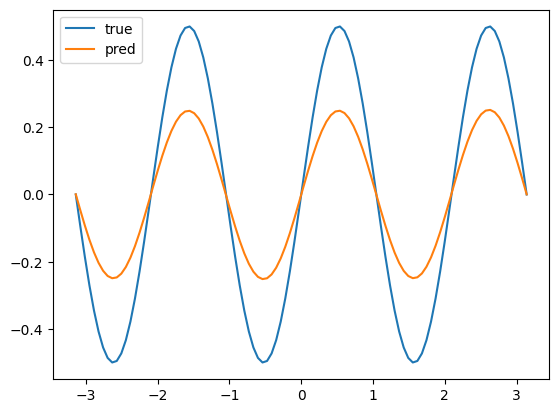

In [38]:
draw(net)

In [28]:
train_lbfgs(net, epochs=50)
torch.save(net.state_dict(), "models/lbfgs")

Started L-BFGS training...


/home/agse/miniconda3/envs/torch/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([100, 1])) that is different to the input size (torch.Size([100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0	 Loss: 0.24757081034308093
Epoch: 1	 Loss: 0.22966396258273916
Epoch: 2	 Loss: 0.20038638715963447
Epoch: 3	 Loss: 0.18106481117711304
Epoch: 4	 Loss: 0.16793154985898187
Epoch: 5	 Loss: 0.15834550057297006
Epoch: 6	 Loss: 0.15109092881857158
Epoch: 7	 Loss: 0.14549033613295634
Epoch: 8	 Loss: 0.14111182406224212
Epoch: 9	 Loss: 0.13765903342622576
Epoch: 10	 Loss: 0.13491935637894245
Epoch: 11	 Loss: 0.13273564350789294
Epoch: 12	 Loss: 0.13098898724057356
Epoch: 13	 Loss: 0.1295882559817683
Epoch: 14	 Loss: 0.1284626454250264
Epoch: 15	 Loss: 0.12755666097143245
Epoch: 16	 Loss: 0.1268265253603347
Epoch: 17	 Loss: 0.12623752064951227
Epoch: 18	 Loss: 0.12576197420273455
Epoch: 19	 Loss: 0.12537780148696842
Epoch: 20	 Loss: 0.1250672681261259
Epoch: 21	 Loss: 0.12481617601618022
Epoch: 22	 Loss: 0.12461306784046441
Epoch: 23	 Loss: 0.12444874418494112
Epoch: 24	 Loss: 0.12431574817795797
Epoch: 25	 Loss: 0.12420811289662036
Epoch: 26	 Loss: 0.12412096875834479
Epoch: 27	 Loss

# Visualising loss landscape

In [2]:
from torch.nn.utils import (
    parameters_to_vector as Params2Vec,
    vector_to_parameters as Vec2Params
)